# Testing how to setup keras and the data generator.

**TOO SLOW**

Using full spectrograms.

Predicting class given by expert_consensus.


In [1]:
import pandas as pd
import numpy as np
import keras
import pathlib
import os 
import matplotlib.pyplot as plt

np.random.seed(536)

base_dir = pathlib.Path("../../kaggle_data/hms")
# base_dir = pathlib.Path("../../data/hms")
# base_dir = pathlib.Path("/kaggle/input/hms-harmful-brain-activity-classification")

2024-01-17 23:00:59.263924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 23:00:59.351976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Classes must be in this order:
# submission: eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
# So pd.factorize is not useful here.

path_train = base_dir / "train.csv"
df_traincsv = pd.read_csv(path_train)
# codes, uniques = pd.factorize(df_traincsv['expert_consensus'], sort=True)
# df_traincsv['target'] = codes 
df_traincsv.loc[df_traincsv.expert_consensus == 'Seizure', 'target'] = 0
df_traincsv.loc[df_traincsv.expert_consensus == 'LPD', 'target'] = 1
df_traincsv.loc[df_traincsv.expert_consensus == 'GPD', 'target'] = 2
df_traincsv.loc[df_traincsv.expert_consensus == 'LRDA', 'target'] = 3
df_traincsv.loc[df_traincsv.expert_consensus == 'GRDA', 'target'] = 4
df_traincsv.loc[df_traincsv.expert_consensus == 'Other', 'target'] = 5

TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

print("Loaded train.csv. Added target column.")

Loaded train.csv. Added target column.


In [3]:
df_traincsv.sample(10)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
95114,3763407676,3,20.0,1926321153,3,20.0,4233515982,17948,LPD,2,5,1,1,0,5,1.0
101589,2882719839,50,242.0,2035369578,50,242.0,3121605305,2641,GPD,5,0,11,0,0,0,2.0
39866,401608387,15,46.0,764146759,962,16440.0,2707932127,30631,LPD,0,9,0,3,0,1,1.0
36268,3601847076,0,0.0,713971237,0,0.0,2864515130,49713,LPD,0,3,0,0,0,0,1.0
18118,138694022,2,4.0,360712835,2,4.0,1174940227,31849,Seizure,3,0,0,0,0,0,0.0
9980,759620270,20,178.0,183066887,33,1154.0,2753292578,55021,LPD,0,4,0,0,0,0,1.0
33281,3550396998,1,24.0,651747669,1,24.0,78322703,17089,Other,0,0,0,0,0,1,5.0
76236,1529950088,3,6.0,1526614019,3,6.0,1708061987,26349,LRDA,0,0,0,2,0,1,3.0
40055,212793838,0,0.0,765753086,8,2384.0,3971267977,31343,Other,0,0,0,0,0,1,5.0
94494,4034388430,0,0.0,1912193552,28,508.0,3071202271,13329,Seizure,3,0,0,0,0,0,0.0


In [7]:
# This is not necessary in production code.
# The dataset is loading inside the data generator.
print("Loading spectrograms parquet and replacing NaN ...", end="")
df = pd.read_parquet('../data/00_single_spectrograms_originals.parquet')
df.replace(np.nan, 0, inplace=True)
print("done.")

Loading spectrograms parquet and replacing NaN ...done.


In [5]:
#
# Train/Validation indexes in df_traincsv
#
# Basic form. Needs to improve. How to stratify?


ptrain = 0.8

#
# Stratification not implemented yet.
#

n_total_samples = df_traincsv.shape[0]
cut = int(ptrain*n_total_samples)
idx = np.random.permutation(n_total_samples)
idx_train = idx[0:cut]
idx_val = idx[cut:]
print("Train samples:", len(idx_train))
print("Validation samples:", len(idx_val))

Train samples: 85440
Validation samples: 21360


How to access each sub spectrogram.

In [12]:
item = df_traincsv.iloc[idx_train[3554]]
columns = df.columns[2:]
dim = (300,400)
image = df.loc[(df.spectrogram_id == item.spectrogram_id)&
       (df.time >= item.spectrogram_label_offset_seconds)&
       (df.time < item.spectrogram_label_offset_seconds + 600)][columns].to_numpy(copy=True).reshape(*dim,1)
image.shape

(300, 400, 1)

Timing the loading of batches.

How to load train and validation from parquet. To implement inside data generator.

In [56]:
df_traincsv.sample(10)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
63926,3131236943,6,30.0,1284692200,6,30.0,3968989651,50963,GRDA,0,0,0,0,3,0,1
2097,848986991,2,6.0,27620585,2,6.0,4266509754,44705,GRDA,0,0,0,0,3,0,1
13696,3953856449,1,2.0,270970691,1,2.0,189045047,48899,Other,0,0,0,0,5,7,4
7697,1731364965,6,24.0,142835949,6,24.0,2286427827,47780,Seizure,3,0,0,0,0,0,5
67153,1722615148,0,0.0,1344747146,0,0.0,1863186940,63645,Other,0,2,0,4,1,8,4
98745,468065295,40,100.0,1987400764,59,1352.0,964850766,16541,LRDA,0,0,0,2,0,1,3
71676,947738762,15,80.0,1441562054,25,614.0,1206621122,7801,GRDA,0,0,0,0,3,0,1
17420,572915748,60,306.0,343526854,60,306.0,2133492129,54253,GRDA,0,0,0,0,3,0,1
102833,815023945,0,0.0,2060670605,82,8844.0,4064257212,55705,LPD,0,1,0,0,0,1,2
18703,525664301,307,760.0,365931891,307,760.0,221252859,27761,LRDA,0,0,0,3,0,0,3


In [6]:
# idx_train[0:10]
items = df_traincsv[['spectrogram_id','spectrogram_label_offset_seconds',
                      'target']].iloc[idx_train[0:10]].reset_index(drop=True)
items

,spectrogram_id,spectrogram_label_offset_seconds,target
0,1926321153,20.0,1.0
1,2035369578,242.0,2.0
2,764146759,16440.0,1.0
3,713971237,0.0,1.0
4,360712835,4.0,0.0
5,183066887,1154.0,1.0
6,651747669,24.0,5.0
7,1526614019,6.0,3.0
8,765753086,2384.0,5.0
9,1912193552,508.0,0.0


In [7]:
sel = [("spectrogram_id", "in", items['spectrogram_id'])]
df_part  = pd.read_parquet('../data/00_single_spectrograms_originals.parquet', filters=sel)
df_part

,spectrogram_id,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,713971237,1,11.130000,11.760000,12.250000,7.440000,7.310000,5.700000,3.850000,2.820000,...,0.08,0.08,0.14,0.15,0.13,0.17,0.08,0.30,0.60,0.65
1,713971237,3,4.880000,5.240000,4.040000,3.800000,3.460000,1.070000,1.670000,0.600000,...,0.05,0.07,0.07,0.09,0.06,0.06,0.07,0.24,0.47,0.49
2,713971237,5,4.470000,5.830000,5.410000,2.470000,2.030000,1.410000,1.050000,1.070000,...,0.06,0.06,0.06,0.06,0.04,0.04,0.05,0.14,0.46,0.44
3,713971237,7,6.130000,7.020000,6.880000,3.450000,2.790000,1.840000,1.230000,1.250000,...,0.03,0.04,0.05,0.04,0.05,0.08,0.05,0.19,0.57,0.55
4,713971237,9,12.320000,12.290000,12.000000,7.500000,3.560000,1.910000,1.660000,1.740000,...,0.06,0.07,0.06,0.09,0.13,0.13,0.12,0.30,0.56,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14920,360712835,637,130.770004,141.320007,145.240005,130.960007,56.810001,49.090000,46.189999,59.830002,...,0.46,0.47,0.65,0.79,0.81,0.74,0.65,0.79,0.83,0.88
14921,360712835,639,90.349998,124.449997,78.860001,84.510002,43.450001,55.389999,36.299999,40.549999,...,0.47,0.47,0.66,0.77,0.71,0.54,0.71,0.81,0.80,0.87
14922,360712835,641,74.750000,82.230003,117.120003,98.699997,58.790001,89.519997,52.009998,43.790001,...,0.34,0.45,0.45,0.42,0.39,0.30,0.30,0.38,0.45,0.45
14923,360712835,643,69.440002,79.779999,76.129997,54.299999,41.880001,41.110001,46.750000,55.970001,...,0.52,0.47,0.39,0.40,0.45,0.51,0.67,0.67,0.52,0.58


In [8]:
index=1
batch_size = 4
indexes = np.arange(items.shape[0])
# Generate indexes of the batch
indexess = indexes[index*batch_size:(index+1)*batch_size]

# Find list of IDs
items_temp = items.iloc[indexess]
items_temp

,spectrogram_id,spectrogram_label_offset_seconds,target
4,360712835,4.0,0.0
5,183066887,1154.0,1.0
6,651747669,24.0,5.0
7,1526614019,6.0,3.0


In [53]:
item = items.iloc[3]
item
# We need to convert to integer back again.

spectrogram_id                      713971237.0
spectrogram_label_offset_seconds            0.0
target                                      2.0
Name: 3, dtype: float64

## Class definition for Data Generator.

In [4]:
#
# Data generator
#

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, items, path_to_data, batch_size=32, dim=(300,400), n_channels=1,
                 n_classes=6, shuffle=True):
        'Initialization'
        sel = [("spectrogram_id", "in", items['spectrogram_id'])]
        self.data = pd.read_parquet(path_to_data, filters=sel)
        self.data.replace(np.nan, 0, inplace=True)
        self.columns = self.data.columns[2:]
        self.dim = dim
        self.batch_size = batch_size
        # self.labels = labels
        self.items = items
        self.len = items.shape[0]
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.len / self.batch_size))+1

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        # items_temp = self.items.iloc[indexes]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.len)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        true_size = len(indexes)
        X = np.empty((true_size, *self.dim, self.n_channels))
        y = np.empty((true_size), dtype=int)

        # Generate data
        for i, idx in enumerate(indexes):
            item = self.items.iloc[idx]
            # Store sample
            X[i,] = self.data.loc[(self.data.spectrogram_id == int(item.spectrogram_id))&
               (self.data.time >= item.spectrogram_label_offset_seconds)&
               (self.data.time < item.spectrogram_label_offset_seconds + 600)][self.columns].to_numpy(copy=True).reshape((*self.dim,1))

            # Store class
            y[i] = int(item.target)

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

## Testing this class

In [5]:
items = df_traincsv[['spectrogram_id','spectrogram_label_offset_seconds',
                      'target']].iloc[idx_train[0:10]].reset_index(drop=True)

# Parameters
params = {
    'dim': (300,400),
    'batch_size': 4,
    'n_classes': 6,
    'n_channels': 1,
    'shuffle': True
    }
path_to_data = '../data/00_single_spectrograms_originals.parquet'

training_generator = DataGenerator(items, path_to_data, **params)


In [6]:
# Number of batches for each epoch.
# The last batch coud be smaller.
training_generator.__len__()

3

In [7]:
X, y = training_generator.__getitem__(2)
print(X.shape, y.shape)

(2, 300, 400, 1) (2, 6)


In [23]:
# This starts a new epoch, shuffling the indexes.
training_generator.on_epoch_end()
X, y = training_generator.__getitem__(2)


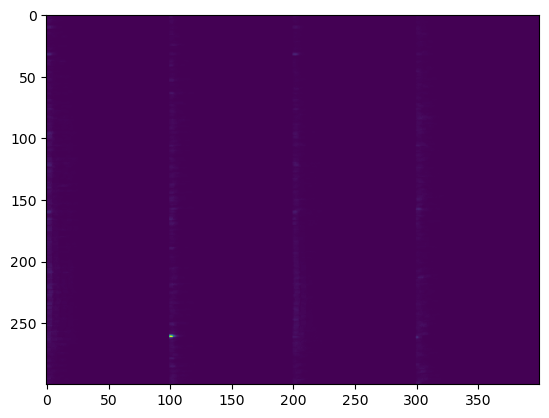

In [109]:
plt.imshow(X[1,:,:,:])

# Skel

This is how the complete script should look like.

In [ ]:
# Parameters
params = {'dim': (32,32,32),
          'batch_size': 64,
          'n_classes': 6,
          'n_channels': 1,
          'shuffle': True}

# Datasets
partition = # IDs
labels = # Labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
model = Sequential()
[...] # Architecture
model.compile()

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6)


# Training

Toy training session.

In [143]:

def make_model(input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)

    #max1 = keras.layers.MaxPooling1D(pool_size=2)(input_layer)
    
    conv1 = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same")(input_layer)
    #conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.MaxPooling2D(pool_size=8)(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=7, padding="same")(conv1)
    #conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.MaxPooling2D(pool_size=8)(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv2D(filters=256, kernel_size=7, padding="same")(conv2)
    #conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.MaxPooling2D(pool_size=2)(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    # conv4 = keras.layers.Conv1D(filters=512, kernel_size=3, padding="same")(conv3)
    # conv4 = keras.layers.BatchNormalization()(conv4)
    # conv4 = keras.layers.MaxPooling1D(pool_size=4)(conv4)
    # conv4 = keras.layers.ReLU()(conv4)

    fltn  = keras.layers.Flatten()(conv3) 
    
    relu1 = keras.layers.Dense(256)(fltn)
    relu1 = keras.layers.ReLU()(relu1)

    relu2 = keras.layers.Dense(64)(relu1)
    relu2 = keras.layers.ReLU(64)(relu2)

    lin = keras.layers.Dense(2)(relu2)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(relu1)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [141]:
items_train = df_traincsv[['spectrogram_id','spectrogram_label_offset_seconds',
                      'target']].iloc[idx_train[0:30]].reset_index(drop=True)
items_val = df_traincsv[['spectrogram_id','spectrogram_label_offset_seconds',
                      'target']].iloc[idx_train[30:40]].reset_index(drop=True)

# Parameters
params = {
    'dim': (300,400),
    'batch_size': 4,
    'n_classes': 6,
    'n_channels': 1,
    'shuffle': True
    }
path_to_data = '../data/00_single_spectrograms_originals.parquet'

training_generator = DataGenerator(items_train, path_to_data, **params)
validation_generator = DataGenerator(items_val, path_to_data, **params)



In [144]:
model = make_model(input_shape=(*params['dim'],1), num_classes=6)
# keras.utils.plot_model(model, show_shapes=True)


In [145]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 400, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 300, 400, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 37, 50, 32)        0         
 g2D)                                                            
                                                                 
 re_lu_5 (ReLU)              (None, 37, 50, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 37, 50, 64)        100416    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 6, 64)          0         
 g2D)                                                      

In [36]:
# model.compile(optimizer=optimizers.Adam(lr=0.001, decay=0.00016667),
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(training_generator, epochs=3, validation_data=validation_generator)
# model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=6)

Epoch 1/3
8/8 [==============================] - 3s 279ms/step - loss: 4962914.5000 - accuracy: 0.1667 - val_loss: 521223.8125 - val_accuracy: 0.1000
Epoch 2/3
8/8 [==============================] - 2s 249ms/step - loss: 698.6718 - accuracy: 0.6000 - val_loss: 418769.0000 - val_accuracy: 0.1000
Epoch 3/3
8/8 [==============================] - 2s 263ms/step - loss: 239.5192 - accuracy: 0.7000 - val_loss: 369270.0000 - val_accuracy: 0.3000


In [37]:
y_pred = model.predict(validation_generator)

3/3 [==============================] - 0s 24ms/step


In [38]:
y_pred

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.9999714e-01, 0.0000000e+00, 8.9911810e-15, 0.0000000e+00,
        0.0000000e+00, 2.8650436e-06],
       [1.9031480e-14, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.3959674e-11],
       [2.3770115e-09, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 8.3674311e-24],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00,

In [45]:
np.round(y_pred[0],3)

array([0., 0., 0., 0., 0., 1.], dtype=float32)

# Generating a submission

For simulating a submission, we need several test spectrograms parquet files and more rows in test.csv.

In [8]:
path_toy = pathlib.Path("../toy_data")

path_test = base_dir / "test.csv"
df_testcsv = pd.read_csv(path_test)
df_testcsv

,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [53]:
f'{base_dir}/test_spectrograms/853520.parquet'

'../../data/hms/test_spectrograms/853520.parquet'

In [54]:
# Test spectrograms are 10 minutes long, no need for offset here.

test_spectrogram = pd.read_parquet(f'{base_dir}/test_spectrograms/853520.parquet')
test_spectrogram.shape

(300, 401)

In [64]:
test_spectrogram.iloc[:,1:]

,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,14.910000,17.110001,11.660000,11.73,6.08,4.54,4.31,3.38,2.05,1.46,...,0.07,0.06,0.05,0.06,0.05,0.05,0.06,0.05,0.04,0.05
1,11.130000,10.950000,10.770000,5.07,4.03,3.24,3.61,2.98,1.54,1.99,...,0.05,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.02
2,10.880000,10.570000,8.790000,5.33,2.44,1.48,1.83,0.99,0.89,0.90,...,0.04,0.04,0.04,0.03,0.03,0.04,0.04,0.05,0.06,0.06
3,19.450001,18.200001,17.719999,13.38,4.17,1.88,1.84,1.22,1.27,1.17,...,0.03,0.03,0.05,0.08,0.07,0.07,0.08,0.03,0.03,0.03
4,21.650000,22.530001,23.160000,17.00,7.19,3.89,3.65,2.72,2.35,2.08,...,0.04,0.04,0.05,0.05,0.06,0.05,0.05,0.05,0.04,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,15.580000,18.209999,14.020000,15.96,4.36,4.98,2.68,2.22,2.03,1.56,...,0.48,0.59,0.59,0.73,0.44,0.41,0.56,0.60,0.61,0.60
296,17.209999,20.219999,20.889999,17.16,9.15,4.14,2.49,2.71,1.60,1.09,...,0.26,0.37,0.41,0.36,0.48,0.36,0.39,0.46,0.34,0.32
297,9.610000,13.320000,9.190000,11.50,8.11,5.53,5.57,3.69,3.19,2.59,...,0.58,0.37,0.17,0.14,0.13,0.30,0.36,0.39,0.56,0.29
298,8.430000,11.840000,13.640000,10.56,8.63,5.80,2.98,1.48,0.96,0.66,...,0.54,0.22,0.17,0.16,0.11,0.38,0.45,0.45,0.45,0.34


In [9]:
# # Generation of a toy test.csv and copy the spectrums parquet files.

# # Always use these same indexes in train csv. Only the parquet files for these
# # spectrograms are present in the toy data.
# train_idxs = [ 33128,  63804,  64923,  92769,  93648,  27624,  98987,  13846,  60697, 
#               87817,  74512,  72883,  79556,  42300,  74248,  19225,  51746, 100555,
#               37036,  99811]
# df_toytest = df_traincsv[['spectrogram_id', 'eeg_id', 'patient_id']].iloc[train_idxs].reset_index(drop=True)
# df_toytest.to_csv(path_toy / 'test.csv', index=False)

# for idx in train_idxs:
#     item = df_traincsv.iloc[idx]
#     df_spec = pd.read_parquet(f'{base_dir}/train_spectrograms/{item.spectrogram_id}.parquet')
#     df_spec = df_spec.loc[(df_spec.time >= item.spectrogram_label_offset_seconds)&
#                 (df_spec.time < item.spectrogram_label_offset_seconds + 600)]
#     df_spec.to_parquet(f'../toy_data/test_spectrograms/{item.spectrogram_id}.parquet')


# # # This would be used for copying files, not needed now.
# # import shutil
# # for id in df_toytest['spectrogram_id'].unique():
# #     source = f'{base_dir}/train_spectrograms/{id}.parquet'
# #     dest = f'{path_toy}/test_spectrograms/{id}.parquet'
# #     shutil.copyfile(source, dest)

In [109]:
# path_to_test_data = f'{base_dir}/test_spectrograms'
path_to_test_data = f'../toy_data/test_spectrograms/'
os.listdir(path_to_test_data)

['1802995379.parquet',
 '1999336047.parquet',
 '2011177737.parquet',
 '1017927461.parquet',
 '373481718.parquet',
 '1279379926.parquet',
 '272214389.parquet',
 '1309472604.parquet',
 '1222625047.parquet',
 '1987874958.parquet',
 '815073191.parquet',
 '1878092388.parquet',
 '1488564716.parquet',
 '536397604.parquet',
 '647711672.parquet',
 '1608390604.parquet',
 '1459125071.parquet',
 '1478824578.parquet',
 '731201762.parquet',
 '1896553221.parquet']

In [147]:
#
# Test Data generator: for predicting.
#

class test_DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, ids, path_to_test_data, batch_size=32, dim=(300,400), n_channels=1,
                n_classes=6):
        'Initialization'
        self.path = path_to_test_data
        # self.files = os.listdir(path_to_test_data)
        self.ids = ids
        self.indexes = np.arange(len(self.ids))
        # self.columns = self.data.columns[2:]
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        # items_temp = self.items.iloc[indexes]

        # Generate data
        X = self.__data_generation(indexes)

        return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # self.indexes = np.arange(self.len)
        # if self.shuffle == True:
        #     np.random.shuffle(self.indexes)
        pass

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(indexes), *self.dim, self.n_channels))

        # Generate data
        for i, idx in enumerate(indexes):
            # item = self.items.iloc[idx]
            test_spectrogram = pd.read_parquet(f'{self.path}{self.ids[idx]}.parquet')
            test_spectrogram.replace(np.nan, 0, inplace=True)

            # Store sample
            X[i,] = test_spectrogram.iloc[:,1:].to_numpy(copy=True).reshape((*self.dim,1))

        return X

Let's test the class.

In [150]:
# Parameters
params = {
    'dim': (300,400),
    'batch_size': 7,
    'n_classes': 6,
    'n_channels': 1,
    }
path_to_test_data = '../toy_data/test_spectrograms/'
toy_test = pd.read_csv('../toy_data/test.csv')
ids = toy_test['spectrogram_id']

test_generator = test_DataGenerator(ids, path_to_test_data, **params)

In [151]:
test_generator.__len__()

3

In [152]:
X = test_generator.__getitem__(1)
X.shape

(7, 300, 400, 1)

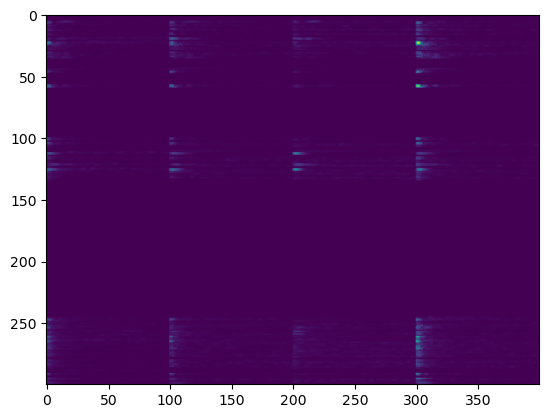

In [153]:
plt.imshow(X[2,:,:,:])

In [154]:
y_pred = model.predict(test_generator)

3/3 [==============================] - 1s 161ms/step


In [155]:
y_pred.shape

(20, 6)

PRoduction code:

In [134]:
test = pd.read_csv('../toy_data/test.csv')
test.head()

,spectrogram_id,eeg_id,patient_id
0,647711672,704367771,53544
1,1279379926,4044323427,56411
2,1309472604,3403081220,24450
3,1878092388,2936526887,61262
4,1896553221,2918575845,17948


In [131]:
# Do some feature engineering.

In [ ]:
# for k in range(len(test)):
#     row = test.iloc[k]
#     s = int( row.spectrogram_id )
#     spec = pd.read_parquet(f'{base_dir}/test_spectrograms/{s}.parquet')
    

In [138]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = np.round(y_pred,3)
sub.to_csv('submission.csv',index=False)
# print('Submissionn shape',sub.shape)
sub

,eeg_id,Seizure,LPD,GPD,LRDA,GRDA,Other
0,704367771,0.0,0.0,0.0,0.0,0.0,1.0
1,4044323427,0.0,0.0,1.0,0.0,0.0,0.0
2,3403081220,0.0,0.0,0.0,0.0,0.0,1.0
3,2936526887,0.0,0.0,0.0,1.0,0.0,0.0
4,2918575845,1.0,0.0,0.0,0.0,0.0,0.0
5,615255846,1.0,0.0,0.0,0.0,0.0,0.0
6,2493948338,0.0,0.0,1.0,0.0,0.0,0.0
7,1405667816,0.0,0.0,0.0,0.0,0.0,1.0
8,983495114,0.0,0.0,0.0,0.0,0.0,1.0
9,2676914434,0.0,0.0,1.0,0.0,0.0,0.0


In [139]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)


0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
dtype: float32